<a href="https://colab.research.google.com/github/danaderp/SecureReqNet/blob/master/alpha_securereqnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alpha-SecureReqNet

In [0]:
#danaderp May6'19
#Prediction For Main Issues Data Set 
#alpha-SecureReqNet

In [0]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
#Importing Neural Dependencies
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

1.14.0


In [0]:
#Visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/secure-req-net')

In [0]:
#! unzip /content/gdrive/My\ Drive/Colab\ Notebooks/secure-req-net/datasets/augmented_dataset/augmented_dataset.zip

In [0]:
#! cp -r issues/ /content/gdrive/My\ Drive/Colab\ Notebooks/secure-req-net/datasets/augmented_dataset/

In [0]:
from vectorize_sentence import Embeddings

In [0]:
from datasets.read_data import Dynamic_Dataset
from datasets.read_data import Processing_Dataset

### Loading word embeddings from previous compression

In [0]:
path = "/content/gdrive/My Drive/Colab Notebooks/secure-req-net/datasets/augmented_dataset/" #Place here the dataset you want to process
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [13]:
dataset = Dynamic_Dataset(ground_truth, path)
test, train = process_unit.get_test_and_training(ground_truth)
print(len(test),len(train))
print(test[0],train[0])

11612 104510
('(1,0)', 'Unspecified vulnerability in the Oracle VM VirtualBox component in Oracle Virtualization VirtualBox before 4.1.32, 4.2.24, and 4.3.10 allows local users to affect confidentiality, integrity, and availability via vectors related to Graphics driver (WDDM) for Windows guests.') ('(1,0)', "'This is a useful security improvement, that I recommend gets integrated into gitlab. It protects users, in the event that their passwords get stolen from other sites, etc. I found a good gem for this: http://rubydoc.info/github/mdp/rotp/master/frames, however, given that it appears Gitlab uses Devise for auth, we should probably use this plugin: https://github.com/wmlele/devise-otp\n\nI intend to submit a Merge Request for this, so I'll outline my design for the system here (in case anyone has feedback/wants to help):\n\n### OTP Strategy\nI'm going with time-based (TOTP). Its requires no storage implications, per-user (other than a 32bit secret key). Time-based keys are very comm

In [0]:
#Preprocesing Corpora
embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [21]:
print(len(pre_corpora_train),len(pre_corpora_test))

103867 11548


In [0]:
#Loading embeddings
embed_path = '/content/gdrive/My Drive/Colab Notebooks/secure-req-net/datasets/augmented_dataset/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)

In [0]:
corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_test]#vectorization

In [0]:
target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output

In [0]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [33]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 618


In [0]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [35]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Min. Sentence # words:",min_len_sentences)

Mix. Sentence # words: 1


In [0]:
embed_size = np.size(corpora_train[0][0])

### Designing Baseline Architecture

In [0]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [38]:
input_sh

(618, 100, 1)

In [39]:
gram_input = Input(shape = input_sh)
# 1st Convolutional Layer Convolutional Layer (7-gram)
conv_1_layer = Conv2D(filters=32, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,embeddigs_cols), padding='valid')(gram_input)
conv_1_layer.shape

W0905 17:47:34.947229 139878436947840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


TensorShape([Dimension(None), Dimension(612), Dimension(1), Dimension(32)])

In [40]:
# Max Pooling 
max_1_pooling = MaxPooling2D(pool_size=((max_len_sentences-7+1),1), strides=None, padding='valid')(conv_1_layer)
max_1_pooling.shape

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(32)])

In [41]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_1_pooling)
fully_connected_1_gram.shape

TensorShape([Dimension(None), Dimension(32)])

In [42]:
fully_connected_1_gram = Reshape((32, 1, 1))(fully_connected_1_gram)
fully_connected_1_gram.shape

TensorShape([Dimension(None), Dimension(32), Dimension(1), Dimension(1)])

In [43]:
# 2nd Convolutional Layer (5-gram)
conv_2_layer = Conv2D(filters=64, kernel_size=(5,1), activation='relu', 
                      padding='valid')(fully_connected_1_gram)
conv_2_layer.shape

TensorShape([Dimension(None), Dimension(28), Dimension(1), Dimension(64)])

In [44]:
max_2_pooling = MaxPooling2D(pool_size=((32-5+1),1), strides=None, padding='valid')(conv_2_layer)
max_2_pooling.shape

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(64)])

In [45]:
# Fully Connected layer
fully_connected_2_gram = Flatten()(max_2_pooling)
fully_connected_2_gram.shape

TensorShape([Dimension(None), Dimension(64)])

In [46]:
fully_connected_2_gram = Reshape((64, 1, 1))(fully_connected_2_gram)
fully_connected_2_gram.shape

TensorShape([Dimension(None), Dimension(64), Dimension(1), Dimension(1)])

In [47]:
# 3rd Convolutional Layer (3-gram)
conv_3_layer =  Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                      padding='valid')(fully_connected_2_gram)
conv_3_layer.shape

TensorShape([Dimension(None), Dimension(62), Dimension(1), Dimension(128)])

In [48]:
# 4th Convolutional Layer (3-gram)
conv_4_layer = Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_3_layer)
conv_4_layer.shape

TensorShape([Dimension(None), Dimension(60), Dimension(1), Dimension(128)])

In [49]:
# 5th Convolutional Layer (3-gram)
conv_5_layer = Conv2D(filters=64, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_4_layer)
conv_5_layer.shape

TensorShape([Dimension(None), Dimension(58), Dimension(1), Dimension(64)])

In [50]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(58,1), strides=None, padding='valid')(conv_5_layer)
max_5_pooling.shape

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(64)])

In [51]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)
fully_connected.shape

TensorShape([Dimension(None), Dimension(64)])

In [52]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(32, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.2)(deep_dense_1_layer) # <-------- [HyperParameter]
deep_dense_1_layer.shape

TensorShape([Dimension(None), Dimension(32)])

In [53]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(32, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.2)(deep_dense_2_layer) # <-------- [HyperParameter]
deep_dense_2_layer.shape

TensorShape([Dimension(None), Dimension(32)])

In [54]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(16, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.2)(deep_dense_3_layer) # <-------- [HyperParameter]
deep_dense_3_layer.shape

TensorShape([Dimension(None), Dimension(16)])

In [0]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [56]:
print(criticality_network.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 618, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 612, 1, 32)        22432     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 1, 1)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 1, 64)         384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0     

In [0]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

### Training the criticality network

In [0]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [0]:
#Memoization 
file_corpora_train_x = path.join(mkdtemp(), '/content/gdrive/My Drive/Colab Notebooks/secure-req-net/alex-res-adapted-003_temp_corpora_train_x.dat') #Update per experiment
file_corpora_test_x = path.join(mkdtemp(), '/content/gdrive/My Drive/Colab Notebooks/secure-req-net/alex-res-adapted-003_temp_corpora_test_x.dat')

In [0]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [0]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [0]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [0]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [64]:
print(corpora_train_x.shape, target_train_y.shape)

(103867, 618, 100, 1) (103867, 2)


In [65]:
print(corpora_test_x.shape,target_test_y.shape)

(11548, 618, 100, 1) (11548, 2)


In [0]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [0]:
#CheckPoints
filepath = "/content/gdrive/My Drive/Colab Notebooks/secure-req-net/best_model.hdf5"

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [73]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=1, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Train on 83093 samples, validate on 20774 samples
83072/83093 [============================>.] - ETA: 0s - loss: 0.1168 - acc: 0.9613

W0905 19:05:23.650168 139878436947840 callbacks.py:989] Can save best model only with val_accuracy available, skipping.


83093/83093 [==============================] - 994s 12ms/sample - loss: 0.1168 - acc: 0.9612 - val_loss: 0.0081 - val_acc: 0.9962


In [0]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
df_history.to_csv('/content/gdrive/My Drive/Colab Notebooks/secure-req-net/history_training.csv', encoding='utf-8',index=False)

In [78]:
criticality_network.save(filepath)
df_history.head()

,loss,acc,val_loss,val_acc
0,0.116789,0.961236,0.008122,0.996245


In [0]:
#Saving Test Data
np.save('/content/gdrive/My Drive/Colab Notebooks/secure-req-net/corpora_test_x.npy',corpora_test_x)
np.save('/content/gdrive/My Drive/Colab Notebooks/secure-req-net/target_test_y.npy',target_test_y)

### Partial Evaluation
To make a deep evaluation, please refer to the "evaluation" notebook.

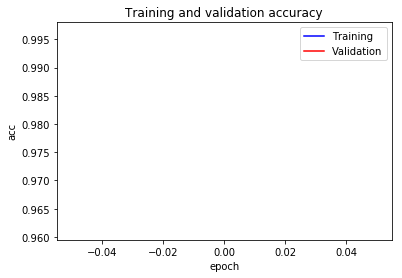

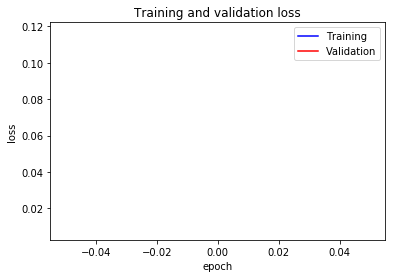

In [82]:
#Evaluation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()